### <center> Assignment 3 Harris Corner Detector & Optical Flow </center>
<center> Computer Vision 1 University of Amsterdam </center>
    <center> Due 23:59, October 1, 2022 (Amsterdam time) </center>

## General Guidelines
Your code and discussion must be completed in this **jupyter notebook** before the deadline by submitting it to the Canvas Lab 3 Assignment. Submit your assignment in a **zip file**, with all the relevant files and images need to run your notebook. Name your zip file as follows:  **StudentID1_StudentID2_StudentID3.zip**
For full credit, make sure your answers follow these guidelines:

- Make sure you use the provided python environment. You can create the environment using conda and the provided YAML file using the following command: `conda env create --file=CV1_env.yaml`, then activate it as `conda activate cv1`. Using different packages versions may result in the impossibility to run the submitted code and therefore in the subtraction of points. Below you will find a code cell to check the versions of your packages. 
- Please express your thoughts concisely. The number of words does not necessarily correlate with how well you understand the concepts.
- Answer all given questions (in **<font color=green >Question** parts). Briefly describe what you implemented. **<font color=blue >Hint** parts are there to give you hints to answer questions.
- Try to understand the problem as much as you can. When answering a question, give evidence (qualitative and/or quantitative results, references to papers, etc.) to support your arguments. Note that not everything might be explicitly asked for and you are expected to think about what might strengthen you arguments and make your notebook self-contained and complete.
- Analyze your results and discuss them, e.g. why algorithm A works better than algorithm B in a certain problem.
- Tables and figures must be accompanied by a brief description. Do not forget to add a number, a title, and if applicable name and unit of variables in a table, name and unit of axes and legends in a figure.
- Make sure all the code in your notebook runs without errors or bugs before submitting. Code that does not run can result in a lower grade. 

**Late submissions** are not allowed. Assignments that are submitted after the strict deadline will not be graded. In case of submission conflicts, TAs’ system clock is taken as reference. We strongly recommend submitting well in advance, to avoid last minute system failure issues.

**Plagiarism note:** Keep in mind that plagiarism (submitted materials which are not your work) is a serious crime and any misconduct shall be punished with the university regulations.

In [1]:
# python packages needed for this assignment
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import signal
from scipy.ndimage import maximum_filter
from scipy import signal 
import os
import matplotlib
import scipy

In [2]:
# Make sure you're using the provided environment!
assert cv2.__version__ == "3.4.2", "You're not using the provided Python environment!"
assert np.__version__ == "1.19.5", "You're not using the provided Python environment!"
assert matplotlib.__version__ == "3.3.4", "You're not using the provided Python environment!"
assert scipy.__version__ == "1.7.3", "You're not using the provided Python environment!"
# Proceed to the next cell if you don't get any error.

## 1. Harris Corner Detector (45pts)
In this section, a derivation of the *[Harris Corner Detector](https://www.semanticscholar.org/paper/A-Combined-Corner-and-Edge-Detector-Harris-Stephens/6818668fb895d95861a2eb9673ddc3a41e27b3b3)* is presented.

Given a shift $(\Delta x,\Delta y)$ at a point $(x, y)$, the auto-correlation function is defined as:

$$c(\Delta x,\Delta y) = \sum\limits_{(x,y)\in W(x,y)} {w(x,y)(I(x+\Delta x,y+\Delta y)-I(x,y))^2} \tag {1}$$

where $W(x,y)$ is a window centered at point $(x,y)$ and $w(x,y)$ is a Gaussian function. For simplicity, from now on, $\sum\limits_{(x,y)\in W(x,y)}$ will be referred to as $\sum\limits_{W}$.
Approximating the shifted function by the first-order Taylor expansion we get:

\begin{eqnarray}
I(x+\Delta x,y+ \Delta y) & \approx & I(x,y) + I_x(x,y)\Delta x + I_y(x,y)\Delta y \tag {2} \\
&=& I(x,y) + [I_x(x,y) \ I_y(x,y)] \begin{bmatrix} \Delta x \\ \Delta y \end{bmatrix}, \tag {3}
\end{eqnarray}

where $I_x$ and $I_y$ are partial derivatives of $I(x,y)$. The first gradients can be approximated by: 
\begin{eqnarray}
    I_x &=& \frac{\partial I}{\partial x} \approx I * G_x, \quad G_x = (-1,0,1) \tag {4} \\ 
    I_y &=& \frac{\partial I}{\partial y} \approx I * G_y, \quad G_y = (-1,0,1)^T \tag {5}
\end{eqnarray}


Note that using the kernel $(-1, 1)$ to approximate the gradients is also correct. The auto-correlation function can now be written as:
\begin{eqnarray}
c(\Delta x,\Delta y) &=& \sum\limits_{W} {w(x,y) (I(x+\Delta x,y+\Delta y)-I(x,y))^2} \tag {6} \\
& \approx & \sum\limits_{W} {w(x,y) ([I_x(x,y) \ I_y(x,y)]\begin{bmatrix} \Delta x \\ 
\Delta y \end{bmatrix})^2} \tag {7} \\
&=& [\Delta x \ \Delta y]Q(x,y)\begin{bmatrix} \Delta x \\ \Delta y \end{bmatrix}, \, \tag {8}
\end{eqnarray}

where $Q(x,y)$ is given by:

\begin{eqnarray}
Q(x,y) &=& \sum\limits_{W} w(x,y){\begin{bmatrix} I_x(x,y)^2  & I_x(x,y)I_y(x,y)  \\  I_x(x,y)I_y(x,y)  & I_y(x,y)^2   \end{bmatrix}} \tag {9} \\
&=& \begin{bmatrix} 
\sum\limits_{W}{I_x(x,y)^2} * w(x, y) & \sum\limits_{W}{I_x(x,y)I_y(x,y)} * w(x, y) \\  
\sum\limits_{W}{I_x(x,y)I_y(x,y)} * w(x, y) & \sum\limits_{W}{I_y(x,y)^2} * w(x, y)  \end{bmatrix} \tag {10}\\
&=& \begin{bmatrix} A & B \\  B & C  \end{bmatrix}.\, \tag {11}
\end{eqnarray}

The *cornerness* $H(x,y)$ is defined by the two eigenvalues of $Q(x,y)$, e.g. $\lambda_1$ and $\lambda_2$:

\begin{eqnarray}
\label{eq12}
H &=& \lambda_1 \lambda_2 - 0.04(\lambda_1 + \lambda_2)^2 \tag{12}\\
&=& det(Q) - 0.04(trace(Q))^2 \tag{13}\\
&=& (AC - B^2) - 0.04(A+C)^2. \ \tag{14}
\end{eqnarray}

In this section, you are going to implement $Equation ~\eqref{eq12}$ to calculate $H$ and use it to detect the corners in an image.

**<font color=blue > Hint**: For that purpose, you need to compute the elements of **Q**, i.e. $A$, $B$ and $C$. To do that, you need to calculate $I_x$, which is the smoothed derivative of the image. That can be obtained by convolving the first order Gaussian derivative, $G_d$, with the image $I$ along the x-direction. Then, **A** can be obtained by squaring $I_x$, and then convolving it with a Gaussian, $G$. Similarly, **B** and **C** can be obtained. For example, to get **C**, you need to convolve the image with $G_d$ along the y-direction (to obtain $I_y$), raise it to the square, then convolve it with $G$. 

**<font color=blue > Hint**: The corner points are the local maxima of **H**. Therefore, you should check for every point in $H$, (1) if it is greater than all its neighbours (in an $n \times n$ window centered around this point) and (2) if it is greater than the user-defined threshold. If both conditions are met, then the point is labeled as a corner point.

**<font color=green > Question - 1 (35-*pts*)**
    
1. Create a function to implement the Harris Corner Detector. Your function should return matrix $H$, the indices of rows of the detected corner points **r**, and the indices of columns of those points **c**, where the first corner is given by $(r[0],c[0])$.

    
2. Implement another function that plots three figures: The computed image derivatives $I_x$ and $I_y$, and the original image with the corner points plotted on it. Show your results on example images **toy/00000001.jpg** and **basketball/085.jpg**. Remember to experiment with different threshold values to see the impact on which corners are found.
    
    
3. Is the algorithm rotation-invariant? How about your implementation? Rotate **toy/00000001.jpg** image 45 and 90 degrees and run the Harris Corner Detector algorithm on the rotated images. Explain your answer and support it with your observations.

*Note:* You are allowed to use *scipy.signal.convolve2d* to perform convolution, and *scipy.ndimage.gaussian\_filter* to obtain your image derivatives. 
Include a demo function to run your code.

**<font color=green > Question - 1.1 answer**

In [51]:
# Q1.1 - helper functions
def load_image_harris(image_dir, rotate_degree):
    img = cv2.imread(image_dir)
    if rotate_degree != 0:
        img = scipy.ndimage.rotate(img, rotate_degree)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = np.float64(img)
    return img

def gauss1D(sigma, kernel_size):
    G = np.zeros((1, kernel_size))
    if kernel_size % 2 == 0:
        raise ValueError('kernel_size must be odd, otherwise the filter will not have a center to convolve on')
    
    G = np.fromfunction(lambda x: np.exp((-1*(x-(kernel_size-1)/2)**2) / (2*sigma**2)), (kernel_size,))
    
    G = G/np.sum(G)
    return G

def gauss2D(sigma_x, sigma_y, kernel_size):
    Gx = gauss1D(sigma_x, kernel_size).reshape((kernel_size,1))
    Gy = gauss1D(sigma_y, kernel_size).reshape((1,kernel_size))
    
    G = Gx @ Gy
    return G

def report_window_sum(i, j, matrix, window_size):
    # returns the sum of all values inside a window applied to matrix with i, j as the center
    half_window = int((window_size-1)/2)
    return np.sum(matrix[i-half_window:i+1+half_window, 
                         j-half_window:j+1+half_window])

In [52]:
# Q1.1 main function
def Harris_corner_detector(sigma_deriv, sigma_kernel, window_size, threshold, image_dir, rotate_degree):
    img = load_image_harris(image_dir, rotate_degree)
    
    # step 1: find smoothed first order partial derivatives
    Ix = scipy.ndimage.gaussian_filter(img, sigma=sigma_deriv, order=[0, 1]) # smoothed first order gaussian along x-axis
    Iy = scipy.ndimage.gaussian_filter(img, sigma=sigma_deriv, order=[1, 0]) # smoothed first order gaussian along y-axis
    
    # step 2: find A, B, C by applying gaussian function to Ix^2, IxIy and Iy^2
    G = gauss2D(sigma_kernel, sigma_kernel, window_size) # gaussian kernel for finding the supports
    A = signal.convolve2d(Ix**2, G, boundary='symm', mode='same')
    B = signal.convolve2d(Ix*Iy, G, boundary='symm', mode='same')
    C = signal.convolve2d(Iy**2, G, boundary='symm', mode='same')
    
    # step 3: calculate H(x, y) for each pixel
    half_window = int((window_size-1)/2)
    [h, w] = img.shape
    H = np.zeros([h, w], dtype=np.float64) # for storing H value at each pixel

    for i in range(half_window, h-half_window): # set boundaries to make sure the window is always contained in the image
        for j in range(half_window, w-half_window):
            a = report_window_sum(i, j, A, window_size)
            b = report_window_sum(i, j, B, window_size)
            c = report_window_sum(i, j, C, window_size)
            H[i, j] = (a*c-b**2)-0.04*(a+c)**2
            
    # step 4: find corners by finding local maximas in H 
    normal_H = cv2.normalize(H, H, 0, 1, cv2.NORM_MINMAX) # All values in H are in (0, 1), easier for thresholding 
    r, c = np.where((maximum_filter(normal_H, size=(window_size, window_size)) == normal_H) & (normal_H > threshold))
    
    return H, r, c

**<font color=green > Question - 1.2 answer**

In [61]:
# Q1.2 - plot the results
def plot_Harris_result(sigma_deriv, sigma_kernel, window_size, threshold, image_dir, rotate_degree):
    
    _, r, c = Harris_corner_detector(sigma_deriv, sigma_kernel, window_size, threshold, image_dir, rotate_degree)

    img_gray = load_image_harris(image_dir, rotate_degree)
    img_colored = cv2.imread(image_dir)
    if rotate_degree != 0:
        img_colored = scipy.ndimage.rotate(img_colored, rotate_degree)

    Ix = scipy.ndimage.gaussian_filter(img_gray, sigma=sigma_deriv, order=[0, 1])
    Iy = scipy.ndimage.gaussian_filter(img_gray, sigma=sigma_deriv, order=[1, 0])


    fig, axs = plt.subplots(3, 1, figsize=(6, 12))
    axs[0].imshow(Ix)
    axs[0].set_title('Partial derivatives along x-direction')
    axs[1].imshow(Iy)
    axs[1].set_title('Partial derivatives along y-direction')
    for i in range(len(r)):
        cv2.circle(img_colored, (c[i], r[i]), 6, (0, 255, 0))
    axs[2].imshow(cv2.cvtColor(img_colored, cv2.COLOR_BGR2RGB))
    axs[2].set_title('Detected corners');

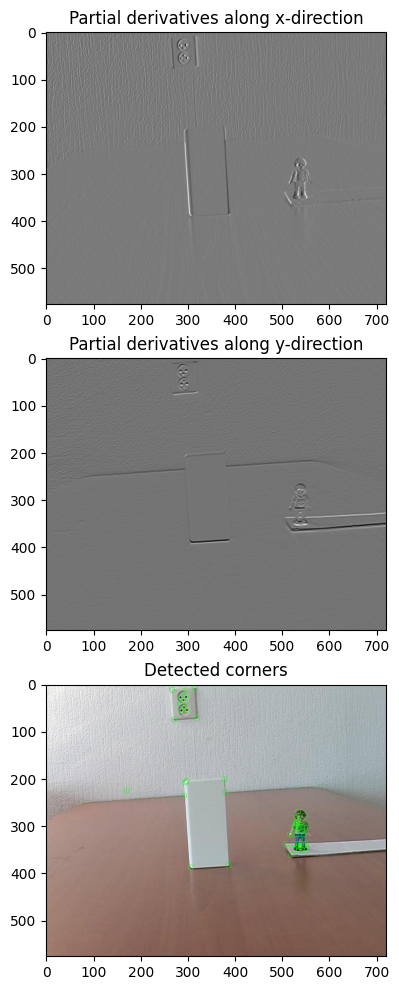

In [44]:
image1_dir = './data/toy/00000001.jpg'
sigma_deriv = 1
sigma_kernel = 0.5
window_size = 5
threshold = 0.0718
rotate_degree = 0
plot_Harris_result(sigma_deriv, sigma_kernel, window_size, threshold, image1_dir, rotate_degree)

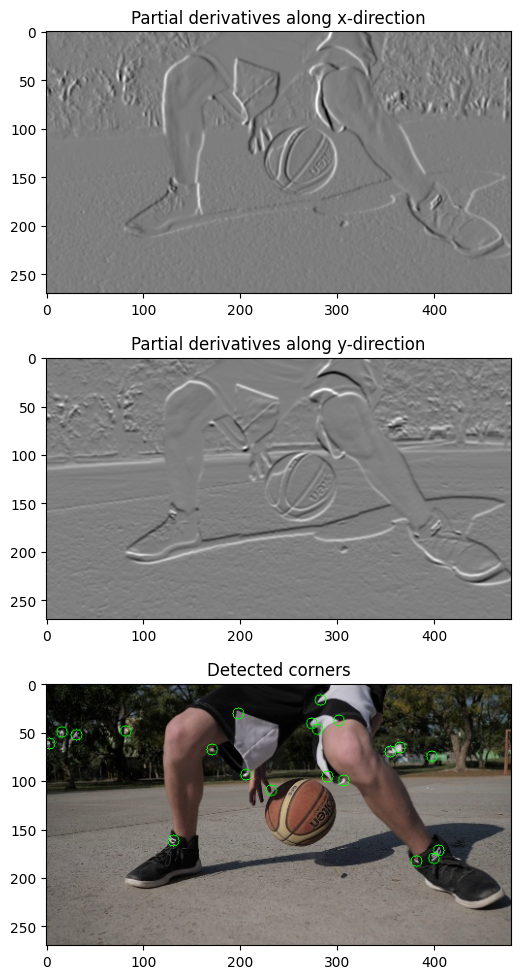

In [60]:
image2_dir = './data/basketball/085.jpg'
sigma_deriv = 1
sigma_kernel = 1
window_size = 7
threshold = 0.4
rotate_degree = 0
plot_Harris_result(sigma_deriv, sigma_kernel, window_size, threshold, image2_dir, rotate_degree)

**<font color=green > Question - 1.3 answer**

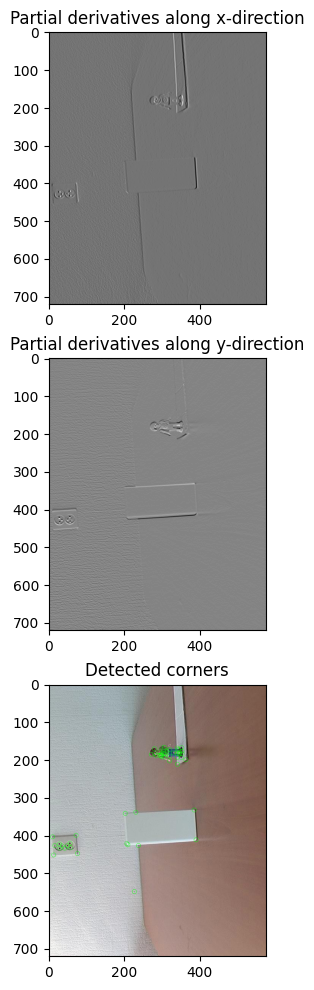

In [57]:
image1_dir = './data/toy/00000001.jpg'
sigma_deriv = 1
sigma_kernel = 0.5
window_size = 5
threshold = 0.0718
rotate_degree = 90
plot_Harris_result(sigma_deriv, sigma_kernel, window_size, threshold, image1_dir, rotate_degree)

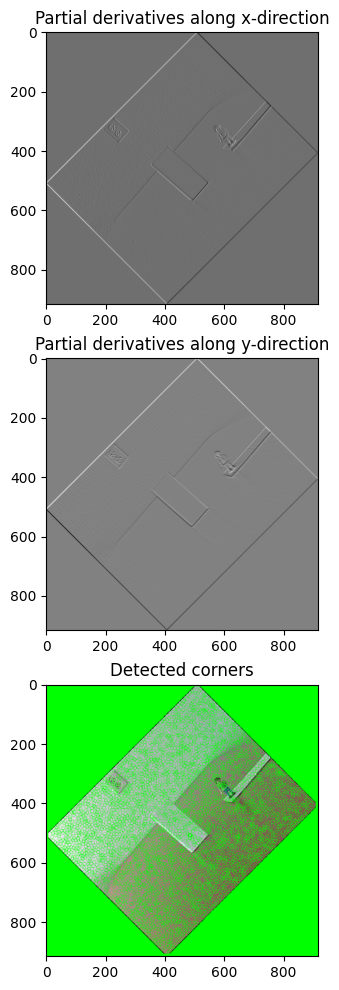

In [54]:
image1_dir = './data/toy/00000001.jpg'
sigma_deriv = 1
sigma_kernel = 0.5
window_size = 5
threshold = 0.0718
rotate_degree = 45
plot_Harris_result(sigma_deriv, sigma_kernel, window_size, threshold, image1_dir, rotate_degree)

Harris corner detector is rotation invariant. in Equation 9 to Equation 12, we see that the value of H(x, y) at each pixel is defined by the eigenvalues of matrix Q(x, y), and eigenvalues define the magnitude of change in the shape of a corner structure given a certain direction (eigenvectors). Since rotation does not change the shape of the corners, these changes evaluated by the eigenvalues do not change either. This concludes that Harris corner detector is rotation invariant.

From the visualizations above, we see that rotating 90 degrees does not affect the detection result, which is a specific case of the above mentioned property. However, rotating 45 degrees gives very messy results. There are possibly two reasons for it. Firstly, rotating by the function in OpenCV automatically paddles the 4 corners in the image with zeros, and these zero will affect the result of finding the response since the content of the image is largely changed. The result becomes especially messy (corners detected in the black corner regions) is because we normalize the H matrix to value (0, 1) in order to get a better feeling of thresholding, however, these zeros then coincidentally got shiftted to above the threshold because the lowest value in H is very small. Secondly, the OpenCV rotation possibly integrates interpolation in order to present better results, this changes the shape of the image in some minor details which possibly further affects the corner detection.

**<font color=green > Question - 2 (10-*pts*)**
    
Now you have seen the cornerness definition of Harris on $Equation ~(12)$. Another relevant definition of cornerness is defined by  *[Shi and Tomasi](https://ieeexplore.ieee.org/document/323794)*, after the original definition of Harris. Check their algorithm and answer the following questions:
    
1. How do they define cornerness? Write down their definition using the notations of $Equation ~(12)$.
    

2. Does the Shi-Tomasi Corner Detector satisfy the following properties: translation invariance, rotation invariance, scale invariance? Explain your reasoning.
    

3. In the following scenarios, what could be the relative cornerness values assigned by Shi and Tomasi? Explain your reasoning.
    
    (a) Both eigenvalues are near 0.
    
    (b) One eigenvalue is big and the other is near zero.
    
    (c) Both eigenvalues are big.

*Q2 - Type your answers here*

## 2. Optical Flow - Lucas-Kanade Algorithm (35pts)

Optical flow is the apparent motion of image pixels or regions from one frame to the next, which results from moving objects in the image or from camera motion. Underlying optical flow is typically an assumption of $\textit{brightness constancy}$. That is the image values (brightness, color, etc) remain constant over time, though their 2D position in the image may change. Algorithms for estimating optical flow exploit this assumption in various ways to compute a velocity field that describes the horizontal and vertical motion of every pixel in the image. For a 2D+t dimensional case a voxel at location $(x, y, t)$ with intensity $I(x, y, t)$ will have moved by $\delta_x$, $\delta_y$ and $\delta_t$ between the two image frames, and the following image constraint equation can be given:

\begin{equation}
I(x,y,t) = I(x+\delta_x, y+\delta_y, t+\delta_t). \tag{15}
\end{equation}

Assuming the movement to be small, the image constraint at I(x, y, t) can be extended using Taylor series, truncated to first-order terms:

\begin{equation}
\tag{16}
I(x+\delta_x, y+\delta_y, t+\delta_t) = I(x,y,t)+\frac{\partial I}{\partial x}\delta_x +\frac{\partial I}{\partial y}\delta_y+\frac{\partial I}{\partial t}\delta_t
\end{equation}

Since we assume changes in the image can purely be attributed to movement, we will get:

\begin{equation}
\tag{17}
\frac{\partial I}{\partial x}\frac{\delta_x}{\delta_t} +   \frac{\partial I}{\partial y}\frac{\delta_y}{\delta_t} + \frac{\partial I}{\partial t}\frac{\delta_t}{\delta_t} = 0
\end{equation}

or

\begin{equation}
\tag{18}
I_x V_x + I_y V_y = -I_t,
\end{equation}

where $V_x$ and $V_y$ are the $x$ and $y$ components of the velocity or optical flow of $I(x,y,t)$. Further, $I_x$, $I_y$ and $I_t$ are the derivatives of the image at $(x, y, t)$ in the corresponding directions, which defines the main equation of optical flow.

Optical flow is difficult to compute for two main reasons. First, in image regions that are roughly homogeneous, the optical flow is ambiguous, because the brightness constancy assumption is satisfied by many different motions. Second, in real scenes, the assumption is violated at motion boundaries and by miscellaneous lighting, non-rigid motions, shadows, transparency, reflections, etc. To address the former, all optical flow methods make some sort of assumption about the spatial variation of the optical flow that is used to resolve the ambiguity. Those are just assumptions about the world which are approximate and consequently may lead to errors in the flow estimates. The latter problem can be addressed by making much richer but more complicated assumptions about the changing image brightness or, more commonly, using robust statistical methods which can deal with 'violations' of the brightness constancy assumption.

### Lucas-Kanade Algorithm

We will be implementing the [Lucas-Kanade method](https://www.ri.cmu.edu/pub_files/pub3/lucas_bruce_d_1981_2/lucas_bruce_d_1981_2.pdf) for Optical Flow estimation. This method assumes that the optical flow is essentially constant in a local neighborhood of the pixel under consideration. Therefore, the main equation of the optical flow can be assumed to hold for all pixels within a window centered at the pixel under consideration. Let's consider pixel $p$. Then, for all pixels around $p$, the local image flow vector $(V_x, V_y)$ must satisfy:

\begin{array}{c}
\tag{19}
  I_x(q_1)V_x + I_y(q_1)V_y = - I_t(q_1)\\
  I_x(q_2)V_x + I_y(q_2)V_y = - I_t(q_2)\\
  \vdots \\
  I_x(q_n)V_x + I_y(q_n)V_y = - I_t(q_n),\\
\end{array}

where $q_1$, $q_2$, ... $q_n$ are the pixels inside the window around $p$. $I_x(q_i)$, $I_y(q_i)$, $I_t(q_i)$ are the partial derivatives of the image $I$ with respect to position $x$, $y$ and time $t$, evaluated at the point $q_i$ and at the current time. 

These equations can be written in matrix to form $Av=b$, where

\begin{equation}
\tag{20}
A = \begin{bmatrix}
I_x(q_1) & I_y(q_1)\\
I_x(q_2) & I_y(q_2)\\
\vdots   & \vdots  \\
I_x(q_n) & I_y(q_n)
\end{bmatrix},
v = \begin{bmatrix}
V_x\\ V_y
\end{bmatrix}, \mbox{ and }
b = \begin{bmatrix}
-I_t(q_1)\\
-I_t(q_2)\\
\vdots   \\
-I_t(q_n)
\end{bmatrix}.
\end{equation}

This system has more equations than unknowns and thus it is usually over-determined. The Lucas-Kanade method obtains a compromise solution by the weighted-least-squares principle. Namely, it solves the $2\times 2$ system as

\begin{equation}
\tag{21}
A^T A v = A^T b
\end{equation}

or

\begin{equation}
v = (A^T A)^{-1} A^T b.
\label{eqA} \tag{22}
\end{equation}

**<font color=green > Question - 1 (30-*pts*)**
    
For this assignment, you will be given three pairs of images: **sphere1.ppm**, **sphere2.ppm**; **synth1.pgm**, **synth2.pgm**; and **monkaa1.png**, **monkaa2.png**. You should estimate the optical flow between these two pairs. That is, you will get optical flow for sphere images, and for synth images separately. Implement the Lucas-Kanade algorithm using the following steps.

    
1. Divide  input  images  on  non-overlapping  regions,  each  region  being  $15\times 15$.
    
    
2. For each region compute $A$, $A^T$ and $b$. Then, estimate optical flow as given in $Equation~\eqref{eqA}$.
    
    
3. When you have estimation for optical flow $(V_x, V_y)$ of each region, you should display the results. There is a **matplotlib** function <font color=green >quiver</font> which plots a set of two-dimensional vectors as arrows on the screen. Try to figure out how to use this to show your optical flow results.

<em>Note</em>: You are allowed to use $\texttt{scipy.signal.convolve2d}$ to perform convolution.
Include a demo function to run your code.

**<font color=blue > Hint**: You can use regions that are $15\times 15$ pixels that are non-overlapping. That is, if input images are $256\times 256$, you should have an array of $17\times 17$ optical flow vectors at the end of your procedure. As we consider $15\times 15$ regions, your matrix $\textbf{A}$ will have the following size $225\times 2$, and the vector $\mathbf{b}$ will be $225\times 1$.

**<font color=blue > Hint**: Carefully read the documentation of $\textbf{matplotlib}'s$ function <font color="green">$\texttt{quiver}$</font>. By default, the angles of the arrows are 45 degrees counter-clockwise from the horizontal axis. This means your arrows might point in the wrong direction! Also, play around with the arrow scaling.

In [17]:
# Q1 - Type your code here

# Q1.1
def divide_images(image, region_size):
    # Calculate how many windows we can create in x and y directions
    img_shape_x = image.shape[0] - (image.shape[0] % region_size)
    img_shape_y = image.shape[1] - (image.shape[1] % region_size)
    
    # Initialize an array to store regions
    array_of_regions = []
    
    # Loop over the full image, slicing the regions
    for i in range(0, img_shape_x, region_size):
        for j in range(0, img_shape_y, region_size):
            window = image[i:(i + region_size), j:(j + region_size)]
            array_of_regions += [window]
            
    return array_of_regions
            
# Q1.2
def get_partials(window):
    in_1 = window
    in_x = np.array([[-1, 0, 1]])
    in_y = in_x.T
    mode = 'same'
    
    dx = signal.convolve2d(in_1, in_x, mode).flatten()
    dy = signal.convolve2d(in_1, in_y, mode).flatten()

    return dx, dy

def get_A_matrices(array_of_regions):
    # Initialize array to store A-matrices in
    array_of_matrices_A = []
    
    for window in array_of_regions:
        array_of_matrices_A += [np.column_stack((get_partials(window)[0], get_partials(window)[1]))]
        
    return np.array(array_of_matrices_A)

def get_B_vectors(windows_img1, windows_img2):
    array_of_B_vectors = []
    size = len(windows_img1)
    
    for window in range(size):
        array_of_B_vectors += [windows_img1[window].flatten() - windows_img2[window].flatten()]
    
    return np.array(array_of_B_vectors)
           
def get_velocity(image1, image2, region_size):
    windows_img1 = divide_images(image1, region_size)
    windows_img2 = divide_images(image2, region_size)
    
    A = get_A_matrices(windows_img1)
    b = get_B_vectors(windows_img1, windows_img2)
    array_of_v = []
    
    for window in range(len(A)):
        array_of_v += [np.linalg.inv(A[window].T @ A[window]) @ (A[window].T @ b[window])]
    
    return np.array(array_of_v)

# Q1.3
def plot_Lucas_Kanade(window_size, img1_dir, img2_dir):   
    # Load the images
    img1 = cv2.cvtColor(cv2.imread(img1_dir), cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(cv2.imread(img2_dir), cv2.COLOR_BGR2GRAY)

    # Get velocities for each window
    V = get_velocity(img1, img2, window_size)

    # Display the results                   
    nr_windows_x = int(np.floor(img1.shape[1] / window_size))
    nr_windows_y = int(np.floor(img1.shape[0] / window_size))
    half_window = int(np.floor(window_size / 2))
    Y, X = np.meshgrid(np.array([half_window+window_size*i for i in range(nr_windows_y)]),
                       np.array([half_window+window_size*i for i in range(nr_windows_x)]))
    plt.figure(figsize=(12, 10))
    plt.imshow(cv2.cvtColor(cv2.imread(img2_dir), cv2.COLOR_BGR2RGB))
    plt.quiver(X.T, Y.T, V[:, 0], V[:, 1], color='r', scale=0.1, angles='xy', scale_units='xy')
    plt.axis('off')
    plt.show()

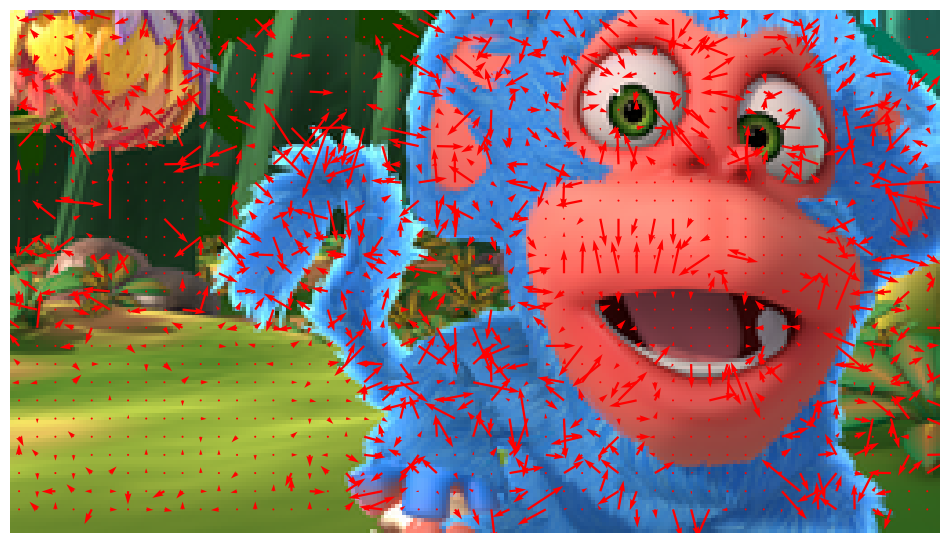

In [18]:
window_size = 5
img1_dir = './data/monkaa1.png'
img2_dir = './data/monkaa2.png'
plot_Lucas_Kanade(window_size, img1_dir, img2_dir)

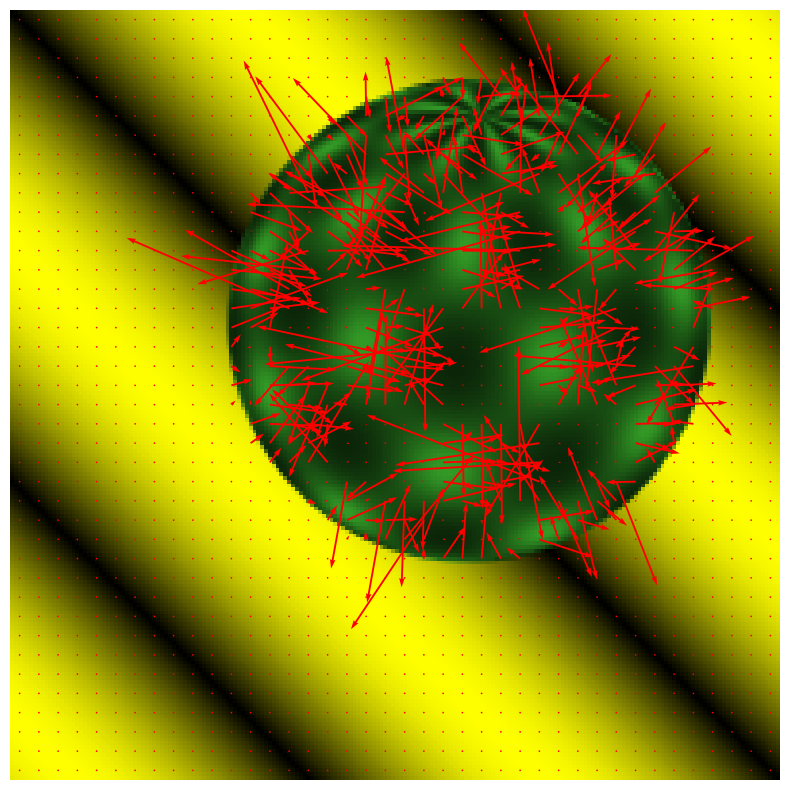

In [19]:
window_size = 5
img1_dir = './data/sphere1.ppm'
img2_dir = './data/sphere2.ppm'
plot_Lucas_Kanade(window_size, img1_dir, img2_dir)

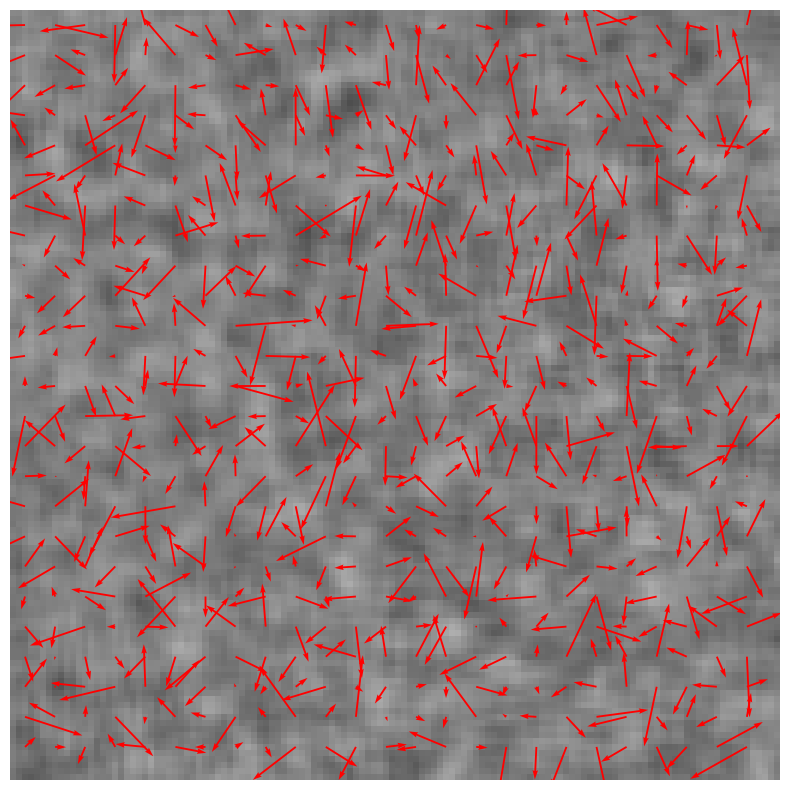

In [24]:
window_size = 5
img1_dir = './data/synth1.pgm'
img2_dir = './data/synth2.pgm'
plot_Lucas_Kanade(window_size, img1_dir, img2_dir)

**<font color=green > Question - 2 (5-*pts*)**

Now you have seen one of the optical flow estimation methods developed by Lucas and Kanade. There are several more methods in the literature. The *[Horn-Schunck method](https://www.sciencedirect.com/science/article/abs/pii/0004370281900242)* is one of them. Check their method, compare it to Lucas-Kanade and answer the following questions:
1. At what scale do the algorithms operate; i.e local or global? Explain your answer.


2. How do the algorithms behave at flat regions?

*Q2 - Type your answers here*

## 3. Feature Tracking (20-pts)

In this part of the assignment, you will implement a simple feature-tracking algorithm. The aim is to extract visual features, like corners, and track them over multiple frames.

**<font color=green > Question - 1 (18-*pts*)**

1. Implement a simple feature-tracking algorithm by following below steps.
    
    (a) Locate feature points on the first frame by using the Harris Corner Detector, that you implemented in Section 1. 
    
    (b) Track these points using the Lucas-Kanade algorithm for optical flow estimation, that you implemented in the Section 2.
    
    
2. Prepare a video for each sample image sequences. These videos should visualize the initial feature points and the optical flow. Test your implementation and prepare visualization videos for **basketball** and **toy** samples.

Include a demo function to run your code.

In [5]:
# Q1 - Type your code here



*Q1 - Type your answers here*

**<font color=green > Question - 2 (2-*pts*)**

Why do we need feature tracking even though we can detect features for each and every frame? 

*Q2 - Type your answers here*